# StarCraft Pro Scout Modeling - K-Nearest Neighbors
- Our first non-parametric algorithm will be K-Nearest Neighbors (KNN), which looks at the neighboring observations of a particular example to determine it's classification.

In [50]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler

# Update sys.path
import sys
sys.path.append("../modules")
from scproModules import print_confusion_matrix, score_df, plot_grid_scores

import pickle

In [17]:
# Pickle opening code to import cleaned data
with open('./pickles/sc_dataclean.pickle','rb') as read_file:
    scns = pickle.load(read_file)

## Compress LeagueIndex Categories
- Ideally we would have two categories, Pro and Non-Pro, but there is so little representation in the Pro category (55 out of 3367) that the class imbalance would be too great to be able to effectively classify.
- As such the positive category, Contender, will be the top three categories (Master, Grandmaster, Pro) and the negative category, Non-Contender, will be the rest of the categories (Bronze, Silver, Gold, Platinum, Diamond). 
- __POSITIVE: Contender (Master, Grandmaster, Pro)__
- __NEGATIVE: Non-Contender (Bronze, Silver, Gold, Platinum, Diamond)__

In [18]:
# Rename labels and resplit. The target label must be 0
scns.LeagueIndex.replace({8:1, 7:1, 6:1, 5:0, 4:0, 3:0, 2:0, 1:0}, inplace=True)

In [19]:
scns.LeagueIndex.value_counts().sort_index()

0    2667
1     700
Name: LeagueIndex, dtype: int64

## Keep Only Non-Parameteric Features

### Target = LeagueIndex

In [20]:
# Our target across all models
y = scns['LeagueIndex']

### Non-Parametric Model Features
Only taking multicollinearity into account we'll update the dataframe to only include the features we want for non-parametric modeling.
- APM
- UniqueHotkeys
- MinimapAttacks
- MinimapRightClicks
- NumberOfPACs
- ActionsInPAC
- WorkersMade
- UniqueUnitsMade
- ComplexAbilityUsed

In [21]:
# Unscaled non-parametric features
np_noscal = scns.copy()
np_noscal = np_noscal[['APM', 'UniqueHotkeys', 'MinimapAttacks',
                       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs',
                       'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 
                       'ComplexAbilityUsed', 'MaxTimeStamp']]

## Standard Scale
- Standard scaling is important for KNN, as it takes Euclidean distance into account when determining neighbors.

In [22]:
# Create scaler, fit and transform
scaler = StandardScaler()
np_scaled = scaler.fit_transform(np_noscal)

## Train-Test Split
- We'll use a simple train test split to create a baseline score to subsequent modeling against.

In [23]:
# Set the split to 75/25 train/test
X_train, X_test, y_train, y_test = train_test_split(np_scaled, y, test_size=0.25, random_state=0)

In [24]:
scns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LeagueIndex         3367 non-null   int64  
 1   APM                 3367 non-null   float64
 2   SelectByHotkeys     3367 non-null   float64
 3   AssignToHotkeys     3367 non-null   float64
 4   UniqueHotkeys       3367 non-null   float64
 5   MinimapAttacks      3367 non-null   float64
 6   MinimapRightClicks  3367 non-null   float64
 7   NumberOfPACs        3367 non-null   float64
 8   GapBetweenPACs      3367 non-null   float64
 9   ActionLatency       3367 non-null   float64
 10  ActionsInPAC        3367 non-null   float64
 11  TotalMapExplored    3367 non-null   float64
 12  WorkersMade         3367 non-null   float64
 13  UniqueUnitsMade     3367 non-null   float64
 14  ComplexUnitsMade    3367 non-null   float64
 15  ComplexAbilityUsed  3367 non-null   float64
 16  MaxTim

- Below we are looking at the recall score of the Contender class, as that is the metric and class we are most interested in. 

# KNN Baseline
- Our baseline should be the result if we did no modeling and chose an exceedingly simple metric, such as the mean of the results, in a regression model. We'll look at this a few different ways. 

In [25]:
# Determine the majority class
y_test.value_counts()

0    653
1    189
Name: LeagueIndex, dtype: int64

## Baseline - Majority Class
- For a __classification algorithm__ with __imbalanced classes__ we should just __choose the majority class__ and __predict everything as the majority class.__

In [26]:
# Change all predictions to 0
y_pred = y_test.replace({1:0})
y_pred.value_counts()

0    842
Name: LeagueIndex, dtype: int64

In [27]:
# Scores
baseline_scores_majority_class = score_df(y_test, y_pred)
baseline_scores_majority_class

/Users/starplatinum87/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Scores
f1,0.000000
precision,0.000000
recall,0.000000
accuracy,0.775534
average_precision,0.224466


- Everything except accuracy was reduced to zero and that would be exceedingly easy for any algorithm to beat, so we need something better.

## Baseline - Positive Class
- Since our metrics are based upon performance for the positive class we can predict everything to be the positive class and see what the results are.


In [28]:
# Change all predictions to 0
y_pred = y_test.replace({0:1})
y_pred.value_counts()

1    842
Name: LeagueIndex, dtype: int64

In [29]:
# Scores
baseline_scores_positive_class = score_df(y_test, y_pred)
baseline_scores_positive_class

,Scores
f1,0.366634
precision,0.224466
recall,1.000000
accuracy,0.224466
average_precision,0.224466


- This is a better 'dumb' metric, except for recall = 1.0, which would be nigh impossible to beat. 
- Let's try for a slightly more sophisticated approach that is still pretty simple.

## Baseline - [Sklearn Dummy Classifier](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)
- Sklearn kindly provides a [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) and [Dummy Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) method to quickly generate baseline values for a model.
- Note that even though these methods take in training arrays they do not use them in their calculation.
- There are many possible strategies:
    - “stratified”: generates predictions by respecting the training set’s class distribution.
    - “most_frequent”: always predicts the most frequent label in the training set.

    - “prior”: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.
    - “uniform”: generates predictions uniformly at random.
    - “constant”: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class
- Many of these end up being similar because we're evaluating an imbalanced class distribution. We'll try out a few to see.

In [30]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred)

/Users/starplatinum87/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Scores
f1,0.000000
precision,0.000000
recall,0.000000
accuracy,0.775534
average_precision,0.224466


- Identical to my majority class approach above... just easier!

In [31]:
clf = DummyClassifier(strategy='constant', constant=1)
clf.fit(X_train, y_train)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred)

,Scores
f1,0.366634
precision,0.224466
recall,1.000000
accuracy,0.224466
average_precision,0.224466


In [32]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred)

,Scores
f1,0.280587
precision,0.202830
recall,0.455026
accuracy,0.476247
average_precision,0.214621


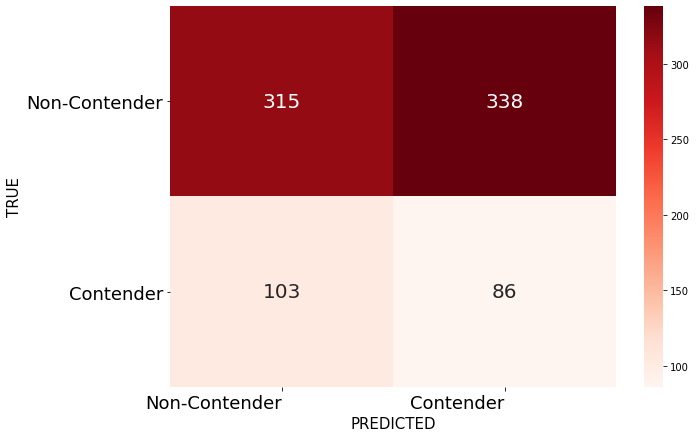

In [33]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_base_pred), 
                      ['Non-Contender', 'Contender'], cmap='Reds')

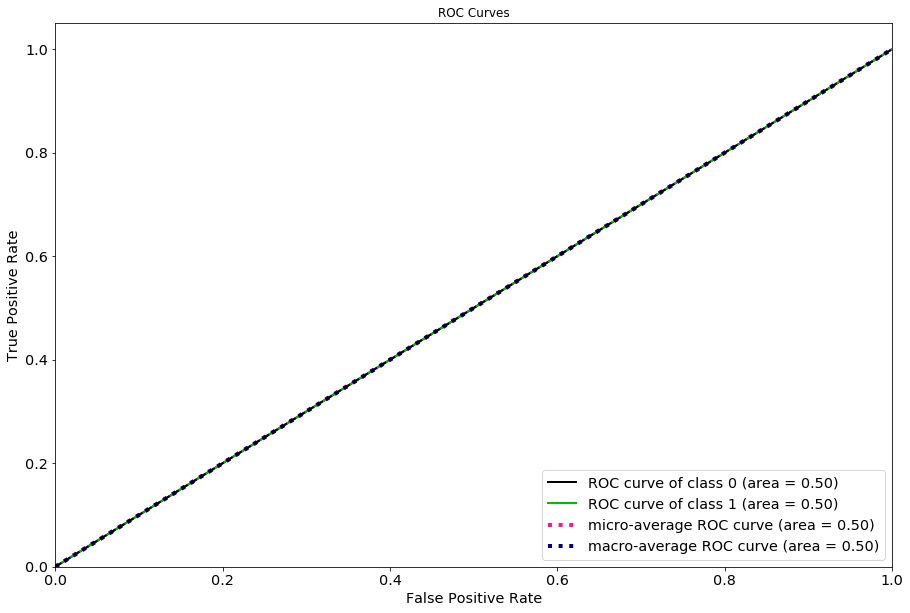

In [34]:
y_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

### Plot Precision-Recall Curve 

#### Establish the Precision-Recall Baseline (0.2245)
- While the baseline for a ROC curve is a slope of 1 with a 0.5 AUC, the baseline for a precision-recall curve is the __proportion of the positive class over the full sample, $y = \frac{P}{(P+N)}$__.
- This is due to the __class imbalance__ between the two classes and we generally __use the precision-recall curve__ when classes are imbalanced.

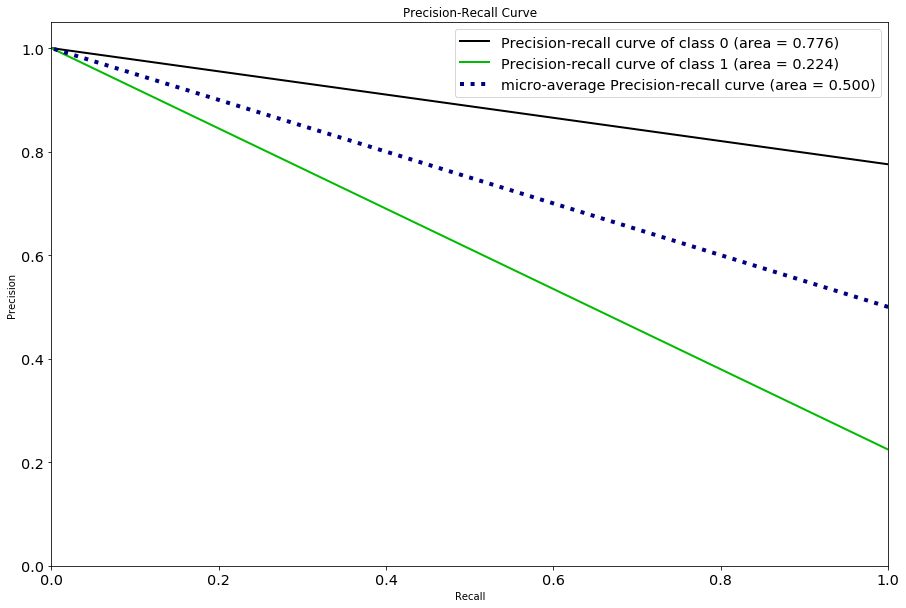

In [35]:
ss

### Baseline Choice - Sklearn DummyClassifier (Uniform)
- While it didn't perform as well as my Expected Value dummy classifier 'uniform' performed the best of the actual dummy baseline, so we'll use those values. 
- Expected Value is interesting, but a tad more complicated than you would probably want out of an actual dummy. Though it is simple, it is a form of aggregation.

# KNN Default Parameters
- We'll start KNN modeling by using the default values for the estimator.

In [36]:
knn1 = KNeighborsClassifier()
knn1.fit(X_train,y_train)
y_pred1 = knn1.predict(X_test)

In [37]:
score_df(y_test, y_pred1)

,Scores
f1,0.498382
precision,0.641667
recall,0.407407
accuracy,0.815914
average_precision,0.394436


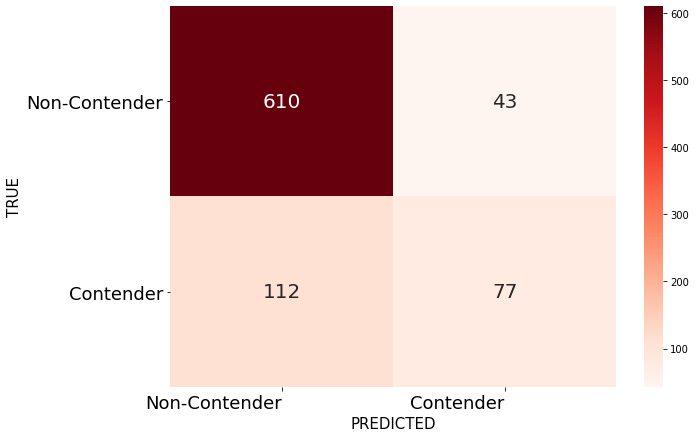

In [38]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred1), 
                      ['Non-Contender', 'Contender'], cmap='Reds')

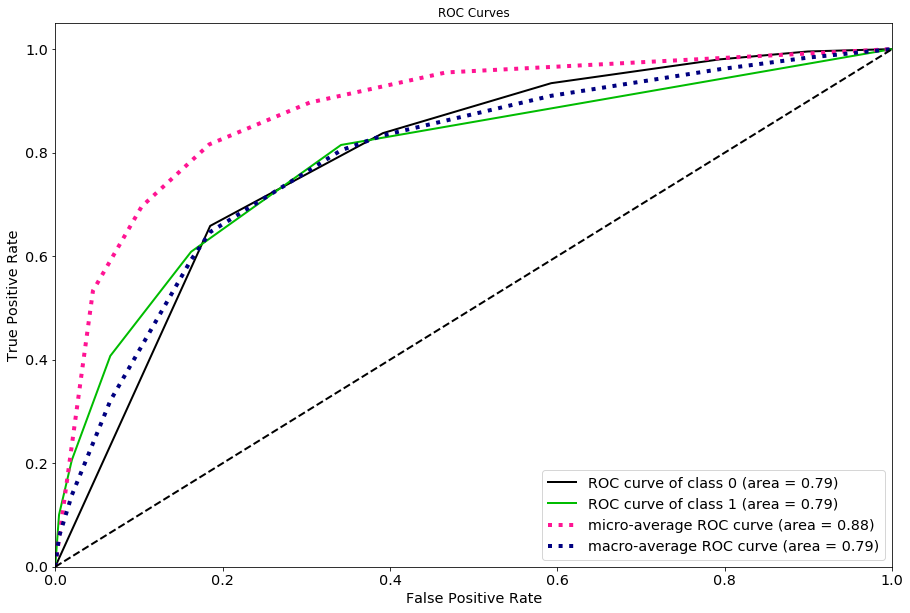

In [39]:
y_probas1 = knn1.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas1, figsize=(15,10), text_fontsize='x-large');

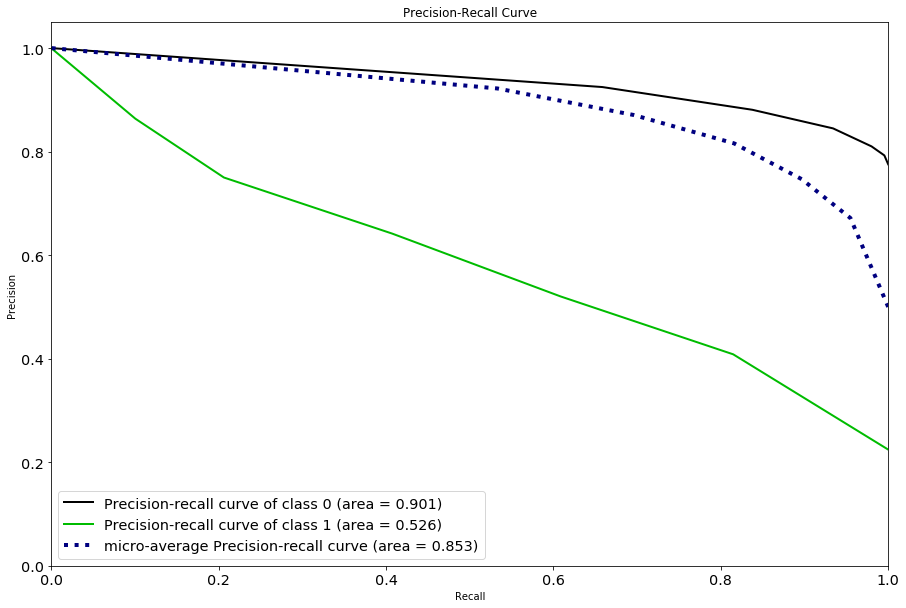

In [40]:
skplt.metrics.plot_precision_recall(y_test, y_probas1, figsize=(15,10), text_fontsize='x-large');

- In general, significant improvements over baseline, which indicates that __the model is doing something__, which is good.
- The only metric that suffered is recall, which is somewhat interesting. It's missing a good deal of the Contender class, which is the one we're most interested in. 
- The ROC and precision-recall curves are significantly improved. 
- Now we'll start searching for the right value of k with GridSearchCV.

# GridSearchCV
- Use GridSearchCV to find the best values.
- We'll start out with a simple grid search.
- Parameters:
    - k-values = [1,100]
    - weights = ['uniform', 'distance']
    - scoring = ['f1', 'precision', 'recall']
    - refit metric = 'f1'
- We're refitting on F1, as I want both precision and recall to be relatively high. 

In [41]:
knn = KNeighborsClassifier()
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc' ]
param_grid = [{'n_neighbors': np.arange(1,101), 'weights': ['uniform', 'distance']}]
knn_grid1 = GridSearchCV(knn, param_grid, scoring=scores, refit='f1')
knn_grid1.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,...
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  9

## KNN GridSearchCV_1 F1 Score: 0.5138

In [42]:
print('Best Parameters:', knn_grid1.best_params_)
print('Best F1 Score:',knn_grid1.best_score_)

Best Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best F1 Score: 0.5138241753879326


- Ever so slight improvement in F1 score.

In [43]:
# Columns for scores df
results_columns = ['mean_test_f1',
 'rank_test_f1',
 'mean_test_precision',
 'rank_test_precision',
 'mean_test_recall',
 'rank_test_recall',
 'mean_test_accuracy',
 'rank_test_accuracy',
 'mean_test_average_precision',
 'rank_test_average_precision',
 'mean_test_roc_auc',
 'rank_test_roc_auc',
 'mean_fit_time',
 'mean_score_time',
 'param_n_neighbors',
 'param_weights']

In [44]:
knn_grid1_df = pd.DataFrame(knn_grid1.cv_results_, columns=results_columns)

In [45]:
pd.DataFrame({'Scores':knn_grid1_df.sort_values(['rank_test_f1']).iloc[0]})

,Scores
mean_test_f1,0.513824
rank_test_f1,1
mean_test_precision,0.624085
rank_test_precision,191
mean_test_recall,0.440225
rank_test_recall,7
mean_test_accuracy,0.831683
rank_test_accuracy,186
mean_test_average_precision,0.529635
rank_test_average_precision,192


In [46]:
knn_grid1_df.sort_values(['rank_test_f1']).head()

,mean_test_f1,rank_test_f1,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_accuracy,rank_test_accuracy,mean_test_average_precision,rank_test_average_precision,mean_test_roc_auc,rank_test_roc_auc,mean_fit_time,mean_score_time,param_n_neighbors,param_weights
8,0.513824,1,0.624085,191,0.440225,7,0.831683,186,0.529635,192,0.811641,191,0.001387,0.043107,5,uniform
9,0.513824,1,0.624085,191,0.440225,7,0.831683,186,0.564677,188,0.811136,192,0.001340,0.032024,5,distance
4,0.506859,3,0.573825,195,0.455892,4,0.820990,194,0.458178,196,0.774410,196,0.001313,0.040143,3,uniform
5,0.506859,3,0.573825,195,0.455892,4,0.820990,194,0.491845,195,0.776252,195,0.001286,0.030688,3,distance
23,0.506696,5,0.677660,174,0.407006,16,0.839604,144,0.622156,171,0.847490,177,0.001309,0.037534,12,distance


- Most metrics have remained about the same vs KNN with default values.
- Of note though is the fact that __average precision is significantly higher: 0.3944 -> 0.5296__.
- However, that __previous score was on test and this score is on cross-validation.__
- Also the __weighting and k values are identical__ which really just tells us that __given these parameters and data,performance on validate and test are pretty similar.__

### KNN Scores Performance
- Let's look at performance over differening values of k

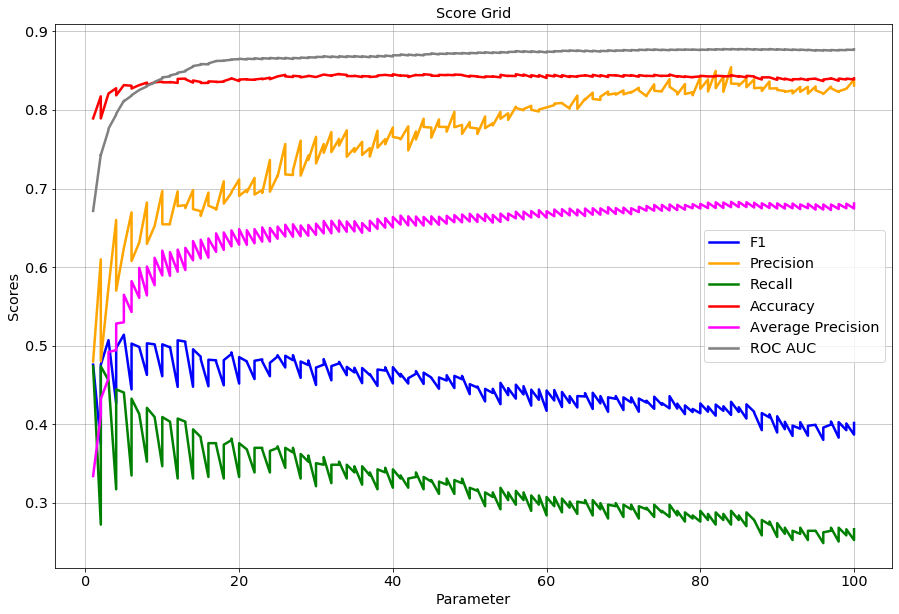

In [49]:
grid1_scores = [knn_grid1_df.mean_test_f1,
                knn_grid1_df.mean_test_precision,
                knn_grid1_df.mean_test_recall,
                knn_grid1_df.mean_test_accuracy,
                knn_grid1_df.mean_test_average_precision,
                knn_grid1_df.mean_test_roc_auc]
grid1_labels = ['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC']
plot_grid_scores(knn_grid1_df.param_n_neighbors, grid1_scores, grid1_labels, linewidth=2.5)

- No big surprises here. As precision goes up recall goes down. A clear negative correlation between the two, as you would expect. 
- ROC AUC and average precision level off around `k=20`.  

## GridSearchCV_2 (Oversampled)
- See if oversampling to even out classes helps.

In [51]:
# Changing cv from 5 to 10
knn_grid2 = GridSearchCV(knn, param_grid, scoring=scores, refit='f1', cv=10)

In [52]:
# RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_sample(X_train,y_train)

In [84]:
# Confirm class balancing
print('RandomOverSampler')
print('Non-Contender: ' + str(list(y_ros).count(0)))
print('Contender: ' + str(list(y_ros).count(1)))

RandomOverSampler
Non-Contender: 2014
Contender: 2014


In [85]:
knn_grid2_ros = knn_grid2
knn_grid2_ros.fit(X_ros, y_ros)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38...
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96, 

In [86]:
print('ROS Best Params:', knn_grid2_ros.best_params_)
print('ROS Best F1 Score:', knn_grid2_ros.best_score_)

ROS Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
ROS Best F1 Score: 0.931252593682073


In [87]:
knn_grid2_ros_df = pd.DataFrame(knn_grid2_ros.cv_results_, columns=results_columns)
pd.DataFrame({'Scores':knn_grid2_ros_df.sort_values(['rank_test_f1']).iloc[0]})

,Scores
mean_test_f1,0.931253
rank_test_f1,1
mean_test_precision,0.875761
rank_test_precision,1
mean_test_recall,0.994527
rank_test_recall,99
mean_test_accuracy,0.926511
rank_test_accuracy,1
mean_test_average_precision,0.873722
rank_test_average_precision,100


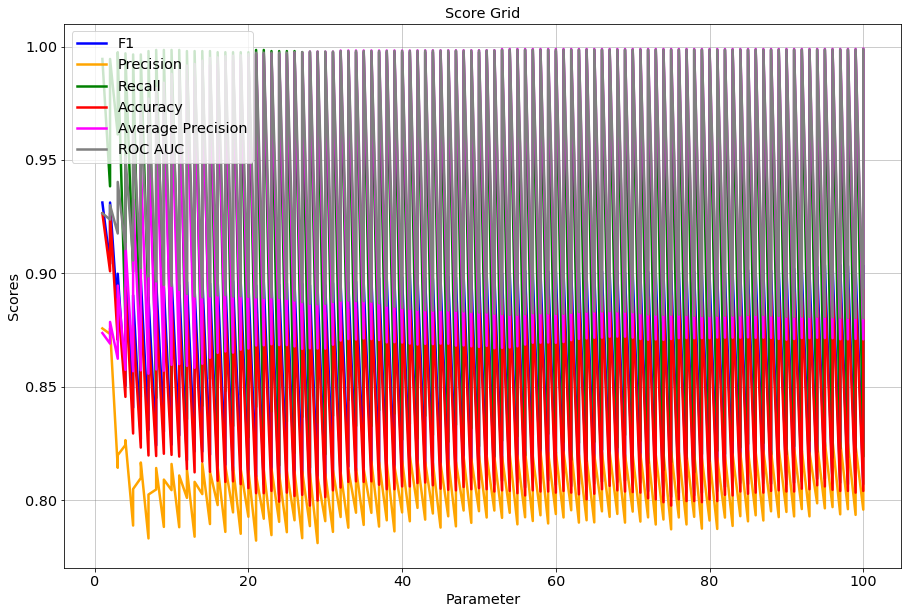

In [88]:
grid2_scores = [knn_grid2_ros_df.mean_test_f1,
                knn_grid2_ros_df.mean_test_precision,
                knn_grid2_ros_df.mean_test_recall,
                knn_grid2_ros_df.mean_test_accuracy,
                knn_grid2_ros_df.mean_test_average_precision,
                knn_grid2_ros_df.mean_test_roc_auc]
grid2_labels = ['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC']
plot_grid_scores(knn_grid2_ros_df.param_n_neighbors, grid2_scores, grid2_labels, linewidth=2.5)

- Hmm, this is... impossible to read. It seems like the two weights may be making the output too noisy. If "uniform" is highly represented in the top F1 scores then we can just assume that "uniform" is the better weighting approach and get a cleaner plot, or simply plot them both separately. 

## GridSearchCV_3 (Oversampled)
- We'll make some changes and run another GridSearchCV

### Weighting = Distance
- Looks like there is no significant difference in representation between distance and uniform weighting in the top 20 scores, so choosing between the two seems not to matter. 
- To confirm let's look at the average scores for each.

In [89]:
uniform_scores = knn_grid2_df.loc[knn_grid2_df['param_weights'] == 'uniform']
distance_scores = knn_grid2_df.loc[knn_grid2_df['param_weights'] == 'distance']
print('Uniform F1: ', uniform_scores.mean_test_f1.mean())
print('Distance F1: ', distance_scores.mean_test_f1.mean())
print('Uniform Average Precision: ', uniform_scores.mean_test_average_precision.mean())
print('Distance Average Precision: ', distance_scores.mean_test_average_precision.mean())

Uniform F1:  0.9352699930814652
Distance F1:  0.9471609914141648
Uniform Average Precision:  0.9831277587222221
Distance Average Precision:  0.9895864263465757


- As suspected, there really isn't a huge difference between uniform and distance in terms of weighting. Since it is slightly higher though, __we'll use distance as our weighting parameter__.

In [90]:
# Create GridSearchCV
knn = KNeighborsClassifier()
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc' ]
param_grid = [{'n_neighbors': np.arange(1,101), 'weights': ['distance']}] # Limiting weight to distance only
knn_grid3 = GridSearchCV(knn, param_grid, scoring=scores, refit='f1')
knn_grid3.fit(X_ros, y_ros)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,...
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  9

In [91]:
print("Best Parameters:", knn_grid3.best_params_)
knn_grid3_df = pd.DataFrame(knn_grid3.cv_results_, columns=results_columns)
pd.DataFrame({'Scores':knn_grid3_df.sort_values(['rank_test_f1']).iloc[0]})

Best Parameters: {'n_neighbors': 1, 'weights': 'distance'}


,Scores
mean_test_f1,0.92584
rank_test_f1,1
mean_test_precision,0.866146
rank_test_precision,1
mean_test_recall,0.994541
rank_test_recall,99
mean_test_accuracy,0.920305
rank_test_accuracy,1
mean_test_average_precision,0.864099
rank_test_average_precision,100


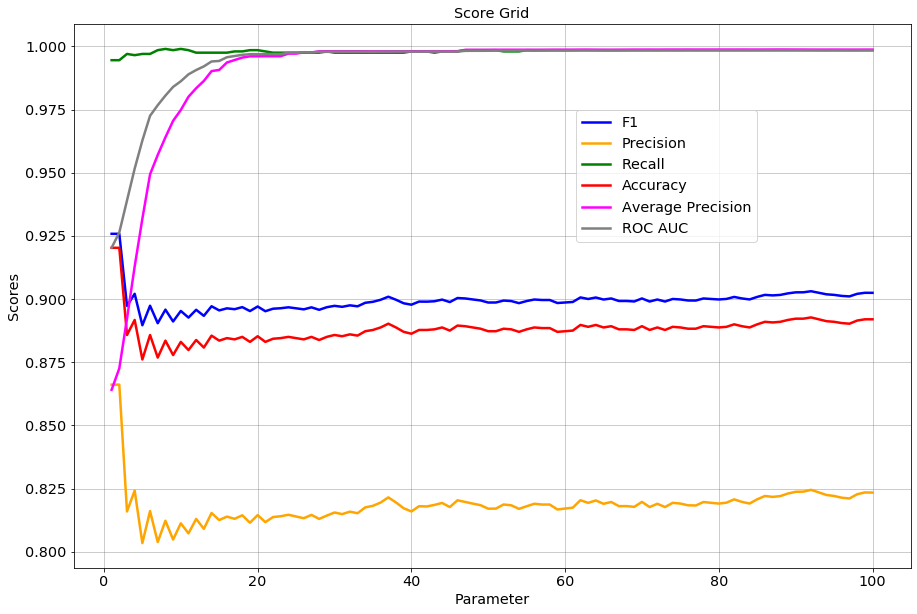

In [98]:
grid3_scores = [knn_grid3_df.mean_test_f1,
                knn_grid3_df.mean_test_precision,
                knn_grid3_df.mean_test_recall,
                knn_grid3_df.mean_test_accuracy,
                knn_grid3_df.mean_test_average_precision,
                knn_grid3_df.mean_test_roc_auc]
grid3_labels = ['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC']
plot_grid_scores(knn_grid3_df.param_n_neighbors, grid3_scores, grid3_labels, linewidth=2.5, loc=(0.6,0.6))

- F1, precision and recall seem to level off around `k=25`. Average precision and ROC AUC seem to level off around a similar range. Let's run another grid search with the range starting around `k=20`.

## GridSearchCV_4 (Oversampled)

### Narrow GridSearchCV Range (`k=20-60`)

In [100]:
# Create GridSearchCV
knn = KNeighborsClassifier()
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc' ]
param_grid = [{'n_neighbors': np.arange(20, 61), 'weights': ['distance']}] # Limiting weight to distance only
knn_grid4 = GridSearchCV(knn, param_grid, scoring=scores, refit='f1')
knn_grid4.fit(X_ros, y_ros)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60]),
                          'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 'precision', 'recall', 'accuracy',
                      'average_precision', 'roc_auc'],
             verbose=0)

In [102]:
print("Best Parameters:", knn_grid4.best_params_)
knn_grid4_df = pd.DataFrame(knn_grid4.cv_results_, columns=results_columns)
pd.DataFrame({'Scores':knn_grid4_df.sort_values(['rank_test_f1']).iloc[0]})

Best Parameters: {'n_neighbors': 37, 'weights': 'distance'}


,Scores
mean_test_f1,0.900944
rank_test_f1,1
mean_test_precision,0.821523
rank_test_precision,1
mean_test_recall,0.997519
rank_test_recall,24
mean_test_accuracy,0.890268
rank_test_accuracy,1
mean_test_average_precision,0.998057
rank_test_average_precision,28


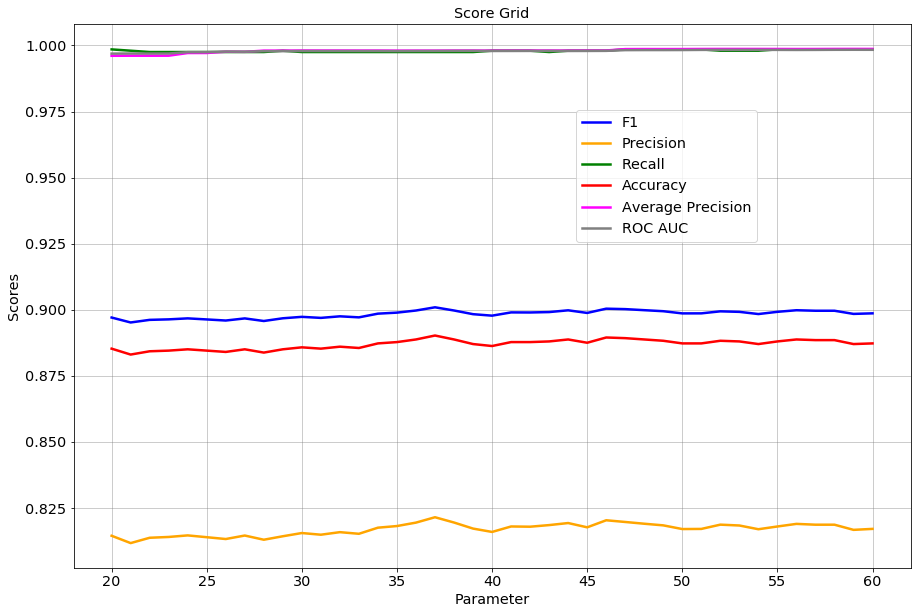

In [103]:
grid4_scores = [knn_grid4_df.mean_test_f1,
                knn_grid4_df.mean_test_precision,
                knn_grid4_df.mean_test_recall,
                knn_grid4_df.mean_test_accuracy,
                knn_grid4_df.mean_test_average_precision,
                knn_grid4_df.mean_test_roc_auc]
grid4_labels = ['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC']
plot_grid_scores(knn_grid4_df.param_n_neighbors, grid4_scores, grid4_labels, linewidth=2.5, loc=(0.6,0.6))

- This is a nice and even plot with much less variance than the lower values of k, hopefully indicating that these results are more generalizable.
- __We'll test the oversampled data with this value of `k=37`__.

## KNN TEST - Cross-Validated Oversampled 
- Details
    - Oversampling: RandomOverSampled
    - n_neighbors: 37
    - Other parameters: default

In [104]:
# Fit estimator
knn = KNeighborsClassifier(n_neighbors=37)
knn.fit(X_ros, y_ros)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                     weights='uniform')

In [105]:
y_pred = knn.predict(X_test)
y_probas = knn.predict_proba(X_test)

### KNN TEST - Scores

In [107]:
# Calculate scores
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

knn_df = pd.DataFrame([f1, precision, recall, accuracy, average_precision, roc_auc], 
                  index=['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC'], 
                  columns=['Scores'])
knn_df

,Scores
F1,0.592902
Precision,0.489655
Recall,0.751323
Accuracy,0.768409
Average Precision,0.423709
ROC AUC,0.762338


- Scores are pretty disappointing. There is  __a significant dip in scores across the board__, indicating __significant overfitting on training vs test__.


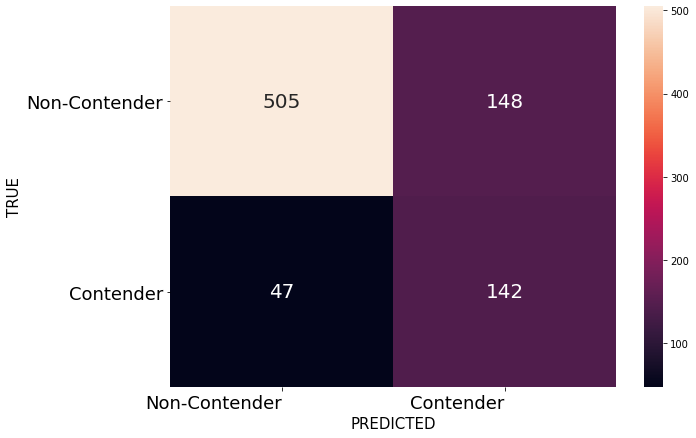

In [108]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      ['Non-Contender', 'Contender'])

- This makes the weakness in precision much clearer. Let's look at the precision-recall curve and ROC curve.

### KNN Test - Precision-Recall Curve

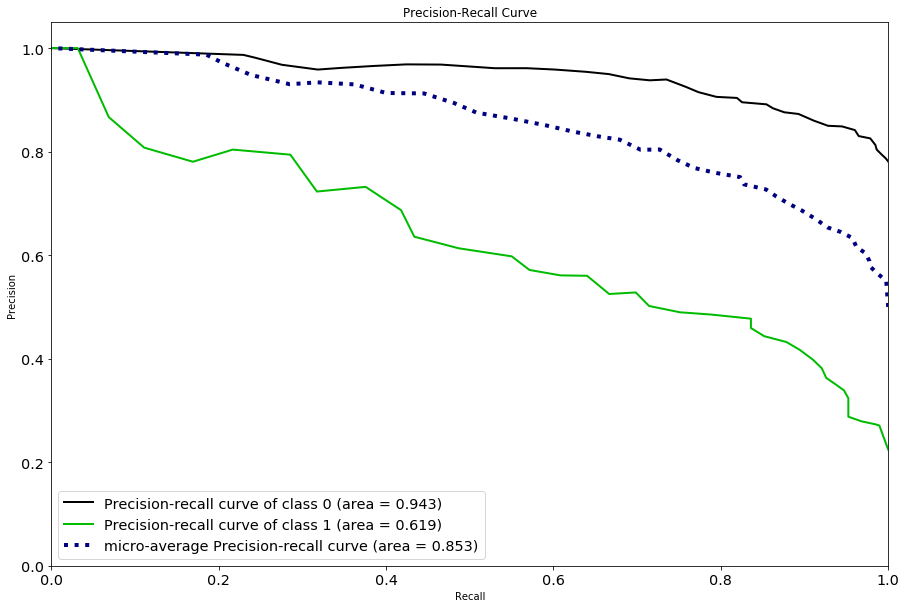

In [109]:
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

### KNN Test - Precision-Recall Thresholds (0.6667)
- Given the curve, what thresholds are optimal?

In [110]:
# View Precision and Recall at specified thresholds
test_prc = precision_recall_curve(y_test, y_probas[:,1])
pd.DataFrame({'Precision':test_prc[0][:-1], 'Recall': test_prc[1][:-1], 'Thresholds':test_prc[2]}).iloc[:,:]

,Precision,Recall,Thresholds
0,0.224466,1.000000,0.000000
1,0.271014,0.989418,0.027027
2,0.273529,0.984127,0.054054
3,0.278963,0.968254,0.081081
4,0.288000,0.952381,0.108108
5,0.297030,0.952381,0.135135
6,0.309278,0.952381,0.162162
7,0.323741,0.952381,0.189189
8,0.339015,0.947090,0.216216
9,0.351190,0.936508,0.243243


- Honestly none of these are great. As one goes up another goes down.
- The best balance between the two is roughly ~0.6 for each which is not great overall, at a decision value of 0.6667. 

### KNN TEST - ROC Curve

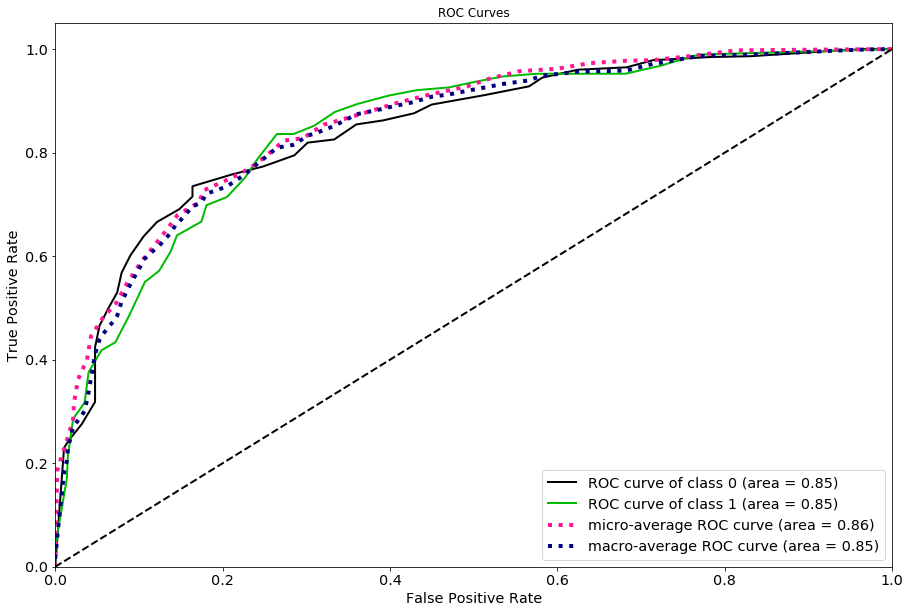

In [111]:
skplt.metrics.plot_roc(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

- The ROC curve implies improvement over the baseline.

### KNN TEST RESULTS
- __Oversampled KNN-CV
    - __F1:__ __<span style="color:blue">0.5929</span>__
    - __Precision:__ __<span style="color:blue">0.4897</span>__
    - __Recall:__ __<span style="color:blue">0.7513</span>__
    - __Accuracy:__ __<span style="color:blue">0.7684</span>__
    - __Average Precision__ __<span style="color:blue">0.4237</span>__
    - __ROC AUC__ __<span style="color:blue">0.7680</span>__
- __SUMMARY__
    - In terms of the metric of interest __Contender Class Recall__, __oversampled KNN-CV__ performed the best with a __recall of 0.6984__.
    - There was a __significant dip in performance on test__ indicating a good degree of __overfitting during training__. We may be able to figure this out with further exploration, but for now we'll move on to other methods. 